matrix transformation only for perfect file (with path 0)

In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os, sys
import shutil
from itertools import islice
from itertools import repeat
from addict import Dict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from chart_studio import plotly
# from chart_studio import pyplot as ply
# import plotly.plotly as py
import plotly.offline as pyoff

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# pymatgen libraries
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
from pymatgen.io.vasp.inputs import Poscar

from get_weirdos_ver3_new_cleaned import splitall, copy_rename_single_file, copy_rename_files_savedir, check_folder_existance
from get_weirdos_ver3_new_cleaned import get_structure_with_library, get_structure_with_linalg, get_structure_with_linalg_combinded_with_library, get_structure_with_linalg_orientated, diagonalizing_latticeconstantsmatrix, get_coor_dict_structure, get_positive_lessthan1_poscarcontcar, mic_eucledian_distance_cartesian, get_flag_map_weirdos_el, rewrite_cif_w_correct_Li_idx, rewrite_cif_w_correct_Li_idx_weirdos_appended, format_spacing_cif, create_cif_pymatgen, ascending_Li, get_latticeconstant_structure_dict_iterated, get_fractional_to_cartesian_matrix, get_fractional_to_cartesian_coor
from get_weirdos_ver3_new_cleaned import get_idx_coor_limapped_weirdos_dict, get_idx_coor_limapped_weirdos_dict_litype, plot_energy_vs_latticeconstant, get_coor_structure24_dict_iterated
from get_weirdos_ver3_new_cleaned import get_dx_dz_init, get_flag_map_weirdos_48htype1_48htype2_el, get_flag_map_weirdos_48htypesmerged_level1_el
from get_weirdos_ver3_new_cleaned import varying_radius_vs_sumweirdosLi, plot_varying_radius_vs_sumweirdosLi, get_orientation
from get_weirdos_ver3_new_cleaned import get_flag_map_weirdos_48htype2_el, get_flag_map_48htypesmerged_el, get_idx_weirdos_el, idx_correcting_mapped_el, create_combine_structure, get_distance_weirdos_label_el, plot_weirdos_directcoor, get_coor_weirdos_array, create_POSCAR_weirdos, kmeans_cluster_weirdos, create_POSCAR_weirdos_centroids_appended, plot_distweirdos, get_label_mapping

direc = os.getcwd() # get current working directory

Parameter to input

In [35]:
poscar_line_nr_start = 8        # index from 0
poscar_line_nr_end = 60
latticeconstantsmatrix_line_nr_start = 2
cif_line_nr_start = 26          # index from 0

amount_Li = 24
reference_Li_nr = 23    # moved Li is placed in nr 23
folder_name_init_system = "/Init_System"

file_new_system = "CONTCAR"
file_init_system = "POSCAR"

col_excel_geo = "geometry"
col_excel_path = "path"
col_excel_toten = "toten [eV]"

amount_P = 4
amount_S = 20
amount_Cl = 4

lattice_constant = 10.2794980000

litype = 2
file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type2" # same as: "Li6PS5Cl_type2_2iia_115_new"

# litype = 3
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3" # use this
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3_opti1"

# litype = 4
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_trial2"

# litype = 5
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5"           # better
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_a"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_b"

file_perfect_poscar_48n24 = f"{file_perfect_poscar_48n24_wo_cif}.cif"

activate_radius = 2 # [1: r1 for 24g 48htype1 48htype2, 2: r2 for 48htype1 48htype2, 3: r3 for 48htype2]
max_mapping_radius = 0.043 # 0.043 ### 0.018 # 0.015 # 0.043
max_mapping_radius_48htype2 = 0.066 # 0.076 ### 0.075 # 0.051 # 0.076
max_mapping_radius_48htype1_48htype2 = (max_mapping_radius + max_mapping_radius_48htype2) / 2
file_perfect_poscar_24 = "Li6PS5Cl_24_mod_2p27291.cif"

file_name_toten = "toten_final.ods"

if activate_radius == 3:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 2:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 1:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}/"
else:
    print("activate_radius is not correct")

# # # # # folder_name_destination_lattice_coeff_input = "/lattice_coeff_input/"
folder_name_perfect_poscar = "/perfect_poscar/"
file_restructure = "CONTCAR"
element_restructure = "P"

cif_columns = ['species', 'idx_species', 'unkownvar_1', 'coord_x', 'coord_y', 'coord_z', 'unkownvar_2']
poscar_columns_type2 = ['coord_x', 'coord_y', 'coord_z', 'species']
contcar_columns_type2 = ['coord_x', 'coord_y', 'coord_z']

var1 and var2 show that arc matters

var2 and var3 show that distance by 0.02ish angstrom in 24g-48h doesn't matter

var3 and var4 show that bigger radius by 0.007 reduce the weirdos each type by around 2

var5 same as var3

var5 and var6 show that bigger radius by 0.009 reduce the weirdos each type by around 4




04_important_outputs_var6 with radius 0.045 and 0.055 show no difference

In [36]:
direc_init_system = direc+str(folder_name_init_system)
# # direc_perfect_system = direc+os.sep+str(file_perfect_poscar_24)
direc_restructure_destination = direc+str(folder_name_destination_restructure)
# # # # # direc_lattice_coeff_input = direc+str(folder_name_destination_lattice_coeff_input)
direc_perfect_poscar = direc+str(folder_name_perfect_poscar)

path_perfect_poscar_24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_24)
path_perfect_poscar_48n24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_48n24)
# path_perfect_poscar_P = os.path.join(direc_perfect_poscar, file_perfect_poscar_P)

In [37]:
dtype = {col_excel_geo: float, col_excel_path: float}

data_toten = pd.read_excel(file_name_toten, dtype=dtype, engine="odf")
data_toten_ori = data_toten
data_toten = data_toten.sort_values(by=["geometry","path"],ignore_index=True,ascending=False)

In [38]:
geometry = np.array([])
path = np.array([])
subdir_col = np.array([])
subdir_col_init_system = np.array([])
subdir_col_perfect_poscar = np.array([])
for subdir, dirs, files in os.walk(direc,topdown=False):
    # source: https://stackoverflow.com/questions/27805919/how-to-only-read-lines-in-a-text-file-after-a-certain-string
    for file in files:
        filepath = subdir + os.sep
        # get directory of CONTCAR
        if os.path.basename(file) == file_new_system:
            geometry_nr = splitall(subdir)[-2]
            path_nr = splitall(subdir)[-1]
            geometry = pd.DataFrame(np.append(geometry, int(geometry_nr)), columns=["geometry"])
            geometry_ori = geometry
            # geometry = geometry.applymap(func=Replace)
            geometry.dropna(axis=1)
            path = pd.DataFrame(np.append(path, int(path_nr)), columns=["path"])
            # path = path.applymap(func=Replace)
            path.dropna(axis=1)
            path_sorted = path.sort_values(by="path",ascending=False)
            subdir_file = os.path.join(subdir,file_new_system)
            # # create directory of POSCAR of init system
            subdir_init_system = direc_init_system + os.sep + geometry_nr + os.sep + path_nr
            # # subdir_file_init_system = os.path.join(subdir_init_system,file_init_system)
            # subdir_file_perfect_poscar = os.path.join()
            subdir_col = pd.DataFrame(np.append(subdir_col, subdir_file), columns=["subdir_new_system"])
            # # subdir_col_init_system = pd.DataFrame(np.append(subdir_col_init_system, subdir_file_init_system), columns=["subdir_init_system"])
            # # subdir_col_perfect_poscar = pd.DataFrame(np.append(subdir_col_perfect_poscar, direc_perfect_system), columns=["subdir_perfect_poscar"])
            file_loc = geometry.join(path)
            file_loc["subdir_new_system"] = subdir_col
            # # file_loc["subdir_init_system"] = subdir_col_init_system
            # # file_loc["subdir_perfect_poscar"] = subdir_col_perfect_poscar
            path_ori = path


In [39]:
# # # file_loc.to_excel(f'file_loc_{var_excel_file}.xlsx', index=False)

In [40]:
file_loc_ori_notsorted = file_loc.copy()
# file_loc_ori_notsorted = file_loc
file_loc = file_loc.sort_values(by=["geometry","path"],ignore_index=True,ascending=False) # sort descendingly based on path

file_loc["g+p"] = (file_loc["geometry"] + file_loc["path"]).fillna(0) # replace NaN with 0
# file_loc["g+p"] = file_loc["geometry"] + file_loc["path"]
file_loc["g+p+1"] = file_loc["g+p"].shift(1)
file_loc["g+p+1"][0] = 0 # replace 1st element with 0
file_loc["g+p-1"] = file_loc["g+p"].shift(-1)
file_loc["g+p-1"][(file_loc["g+p-1"]).size - 1] = 0.0 # replace last element with 0
file_loc["perfect_system"] = file_loc["g+p"][(file_loc["g+p+1"] > file_loc["g+p"]) & (file_loc["g+p-1"] > file_loc["g+p"])]
file_loc["perfect_system"][file_loc["geometry"].size-1] = 0.0 # hardcode the path 0/0
file_loc["p_s_mask"] = [0 if np.isnan(item) else 1 for item in file_loc["perfect_system"]]
# # subdir_filtered = file_loc["subdir"] * file_loc["p_s_mask"]


if data_toten[col_excel_geo].all() == file_loc["geometry"].all() & data_toten[col_excel_path].all() == file_loc["path"].all():
    file_loc[col_excel_toten] = data_toten[col_excel_toten]
else:
    print("check the compatibility of column geometry and path between data_toten file and file_loc")

/tmp/ipykernel_2229793/2773339860.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2229793/2773339860.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2229793/2773339860.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Delete all elements in CONTCAR except Phospor

#### Copy into new directory and rename files

In [41]:
# just refreshing folder
check_folder_existance(direc_restructure_destination)

In [42]:
# just copy file
copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)
copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_48n24, prefix=None)

### Use get_translational_matrix
alternative to get_transformation() from pymatgen: find_primitive() from spglib

In [43]:
# # file_loc_mask_1, file_loc_important_cols = get_orientation(file_loc, orientation=False)

# Now Processing with other folders that are with mask = 0 (not perfect system)

#### copy the data of scaling and translation to the file_loc as initial data

In [44]:
file_loc_mask_1, file_loc_important_cols = get_orientation(file_loc, direc_restructure_destination, file_restructure, path_perfect_poscar_24, col_excel_toten, orientation="False")

In [45]:
# just copy file
copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)

file_loc_important_cols = file_loc.copy()
copy_rename_files_savedir(file_loc_important_cols, direc_restructure_destination, file_restructure, prefix=None)

In [46]:
file_loc_important_cols['subdir_new_system'][0]

'/home/azka/01_Masterthesis/01_Precondition/Masterthesis_split_litype_radius/8/3/CONTCAR'

In [47]:
file_loc_important_cols.head() #####

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_CONTCAR
0,8.0,3.0,/home/azka/01_Masterthesis/01_Precondition/Mas...,11.0,0.0,10.0,NaN,0,-271.373566,/home/azka/01_Masterthesis/01_Precondition/Mas...
1,8.0,2.0,/home/azka/01_Masterthesis/01_Precondition/Mas...,10.0,11.0,9.0,NaN,0,-271.923755,/home/azka/01_Masterthesis/01_Precondition/Mas...
2,8.0,1.0,/home/azka/01_Masterthesis/01_Precondition/Mas...,9.0,10.0,8.0,NaN,0,-271.907989,/home/azka/01_Masterthesis/01_Precondition/Mas...
3,8.0,0.0,/home/azka/01_Masterthesis/01_Precondition/Mas...,8.0,9.0,12.0,8.0,1,-268.234411,/home/azka/01_Masterthesis/01_Precondition/Mas...
4,7.0,5.0,/home/azka/01_Masterthesis/01_Precondition/Mas...,12.0,8.0,11.0,NaN,0,-271.296558,/home/azka/01_Masterthesis/01_Precondition/Mas...


#### Convert new cif file of orientated structure into only positive value

TO DO: add subdir for lattice constant into file_loc

In [48]:
# # # # # def copy_rename_files_subpaths_latticecoeff(file_loc, source_directory, direc_lattice_coeff_input, var_filename, index):
# # # # #     file_loc['subdir_lattice_coeff_input'] = None

# # # # #     filename_to_copy = f"{int(file_loc['geometry'][index])}_{int(file_loc['path'][index])}_POSCAR_{var_filename}"
# # # # #     source_path = os.path.join(source_directory, filename_to_copy)
    
# # # # #     subdir_lattice_coeff_input = direc_lattice_coeff_input + str(int(file_loc['geometry'][index])) +  "/" + str(int(file_loc['path'][index])) + "/"
# # # # #     new_filename = "POSCAR"
# # # # #     destination_path = os.path.join(subdir_lattice_coeff_input, new_filename)

# # # # #     # check existance and emptying it
# # # # #     check_folder_existance(subdir_lattice_coeff_input)
# # # # #     # Copy the file to the destination directory with the new name
# # # # #     shutil.copy2(source_path, destination_path)
# # # # #     print(f"File copied and renamed: {filename_to_copy} -> {destination_path}")

In [49]:
# # # # # var_filename = "trf_w_linalg_orientated_positive_lessthan1_diagonalizedconstants"

# # # # # for index in range(file_loc_important_cols["geometry"].size):
# # # # #     copy_rename_files_subpaths_latticecoeff(file_loc_important_cols, direc_restructure_destination, direc_lattice_coeff_input, var_filename, index)

#### Mapping to the closest neighbor

In [50]:
# from pymatgen.analysis.local_env import CrystalNN

# max_mapping_radius = 0.05282658993283027
# max_mapping_radius = 0.045
# max_mapping_radius = 0.055
# max_mapping_radius = 0.04197083906

ref_structure_48n24 = Structure.from_file(path_perfect_poscar_48n24)

#### Filter only moving the Li-ions from 24g to 24g+48h

In [51]:
coor_structure_init_dict = get_coor_dict_structure(ref_structure_48n24)

get_positive_lessthan1_poscarcontcar(file_loc_important_cols, direc_restructure_destination, poscar_line_nr_start, poscar_line_nr_end, contcar_columns_type2, file_type = "CONTCAR", var_name_in = None, var_name_out = "positive", n_decimal=16)
get_coor_structure24_dict_iterated(file_loc_important_cols, mapping = "False")

if activate_radius == 3:
    get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius)
    get_flag_map_weirdos_48htype1_48htype2_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius_48htype1_48htype2)
    get_flag_map_weirdos_48htypesmerged_level1_el(file_loc_important_cols, "Li")
    get_flag_map_weirdos_48htype2_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius_48htype2, activate_radius)
    get_flag_map_48htypesmerged_el(file_loc_important_cols, "Li", activate_radius)
elif activate_radius == 2:
    get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius)
    get_flag_map_weirdos_48htype2_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius_48htype2, activate_radius)
    get_flag_map_48htypesmerged_el(file_loc_important_cols, "Li", activate_radius)
elif activate_radius == 1:
    get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "Li", max_mapping_radius)

# get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "P", max_mapping_radius)
# get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "S", max_mapping_radius)
# get_flag_map_weirdos_el(file_loc_important_cols, coor_structure_init_dict, "Cl", max_mapping_radius)

/home/azka/01_Masterthesis/01_Precondition/Masterthesis_split_litype_radius/get_weirdos_ver3_new_cleaned.py:665: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/01_Masterthesis/01_Precondition/Masterthesis_split_litype_radius/get_weirdos_ver3_new_cleaned.py:665: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/01_Masterthesis/01_Precondition/Masterthesis_split_litype_radius/get_weirdos_ver3_new_cleaned.py:665: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

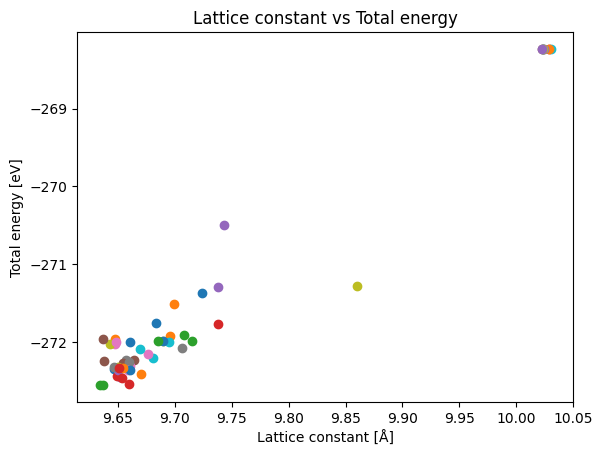

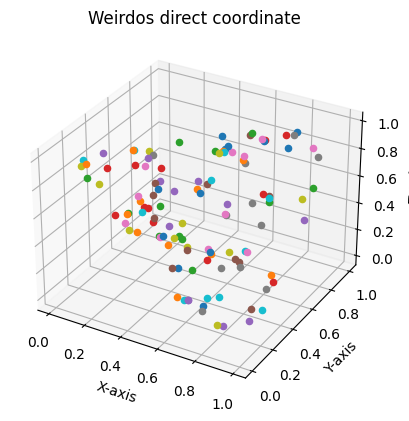

In [52]:
get_idx_weirdos_el(file_loc_important_cols, "Li", activate_radius)

# # idx_correcting_mapped_el(file_loc_important_cols, el="Li")
idx_correcting_mapped_el(file_loc_important_cols, "Li", activate_radius)
# create_combine_structure(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, var_savefilename = "mapLi")

get_distance_weirdos_label_el(file_loc_important_cols, coor_structure_init_dict, "Li", litype)

create_combine_structure(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, activate_radius, var_savefilename = "mapLi")
rewrite_cif_w_correct_Li_idx(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, amount_Cl, var_savefilename_init = "mapLi", var_savefilename_new = "mapLi_reindexed")
format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed", var_savefilename_new = "mapLi_reindexed")
# # # # delete_files(file_loc_important_cols, direc_restructure_destination, file_name_w_format = "mapLi_reindexed.cif")

rewrite_cif_w_correct_Li_idx_weirdos_appended(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, amount_Cl, activate_radius,var_savefilename_init = "mapLi", var_savefilename_new = "mapLi_reindexed_weirdos_appended")
format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed_weirdos_appended", var_savefilename_new = "mapLi_reindexed_weirdos_appended")
# # # delete_files(file_loc_important_cols, direc_restructure_destination, file_name_w_format = "mapLi_reindexed_weirdos_appended.cif")

# # # # create_cif_pymatgen(file_loc_important_cols, direc_restructure_destination, file_restructure, var_name = "CONTCAR_pymatgen")

# # # ascending_Li(file_loc_important_cols, direc_restructure_destination, var_filename_init = "mapLi_reindexed_weirdos_appended", var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")
# # # format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed_weirdos_appended_reordered", var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")

get_idx_coor_limapped_weirdos_dict_litype(file_loc_important_cols, coor_structure_init_dict, activate_radius, litype, el="Li")

get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "CONTCAR")
plot_energy_vs_latticeconstant(file_loc_important_cols, var_filename = "CONTCAR")
plot_weirdos_directcoor(file_loc_important_cols, activate_radius)

coor_weirdos_Li = get_coor_weirdos_array(file_loc_important_cols, activate_radius)
create_POSCAR_weirdos(coor_weirdos_Li, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos")

get_label_mapping(file_loc_important_cols, coor_structure_init_dict, "Li", activate_radius, litype)

In [53]:
dataframe = file_loc_important_cols
el = "Li"

col_atom_mapping_el_w_dist_label = f"atom_mapping_{el}_w_dist_label"

dist_weirdos_el_appendend = []
label_weirdos_el_appended = []

for idx in range(dataframe["geometry"].size):
    atom_mapping_el_w_dist_label = dataframe.at[idx, col_atom_mapping_el_w_dist_label]

    for i in atom_mapping_el_w_dist_label.values():
        dist = i[0]['dist']
        label = i[1]['label']

        dist_weirdos_el_appendend.append(dist)
        label_weirdos_el_appended.append(label)

df = pd.DataFrame({'dist': dist_weirdos_el_appendend, 'label': label_weirdos_el_appended})

fig = px.scatter(df, 
                x = 'label', 
                y = 'dist',
                title = 'Mapped atom type vs its distance'
                )

fig.show(config={'scrollZoom': True})

In [54]:
df_24g = df.loc[df['label'] == '24g']

(array([  4., 216.,   7.,   7.,   6.,   1.,   3.,   2.,   6.,   4.,   7.,
          3.,   3.,   3.,   8.]),
 array([0.00190019, 0.00463844, 0.0073767 , 0.01011495, 0.0128532 ,
        0.01559145, 0.0183297 , 0.02106795, 0.0238062 , 0.02654445,
        0.02928271, 0.03202096, 0.03475921, 0.03749746, 0.04023571,
        0.04297396]),
 <BarContainer object of 15 artists>)

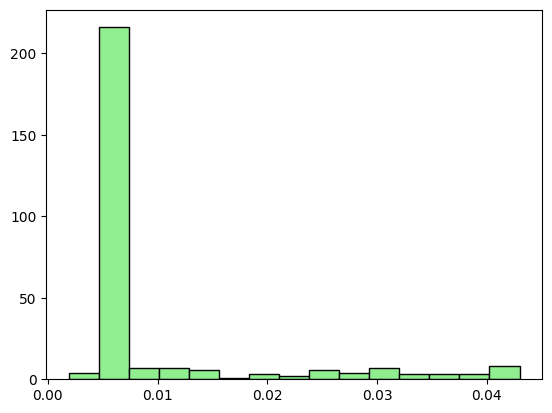

In [55]:
plt.hist(df_24g['dist'], color='lightgreen', ec='black', bins=15)

(array([  3.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,  61., 141.,   9.,
          3.,   0.,   1.,   0.,   1.,   3.,   0.,   1.,   1.,   0.,   1.,
          2.,   1.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   2.,
          3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   4.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,
          0.,   2.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   2.,   1.,   1.,   0.,   2.,   1.,
          2.]),
 array([0.00190019, 0.00231093, 0.00272167, 0.00313241, 0.00354314,
        0.00395388, 0.00436462, 0.00477536, 0.00518609, 0.00559683,
        0.00600757, 0.00641831, 0.00682905, 0.00723978, 0.00765052,
        0.00806126, 0.008472  , 0.00888273, 0.00929347, 0.00970421,
        0.01011495, 0.01052568, 0.01093642, 0.

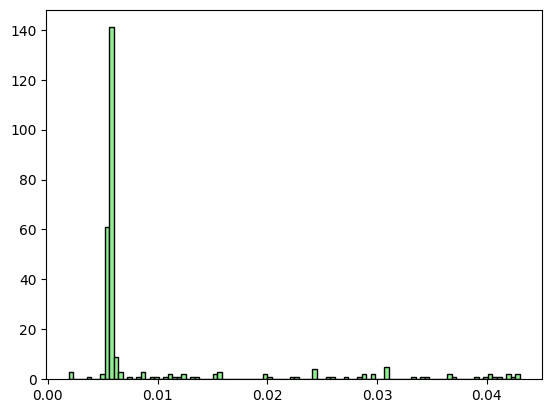

In [62]:
plt.hist(df_24g['dist'], color='lightgreen', ec='black', bins=100)

# K-means analysis

/home/azka/anaconda3/envs/azka311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f968c1bae80>
Traceback (most recent call last):
  File "/home/azka/anaconda3/envs/azka311/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/azka/anaconda3/envs/azka311/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/azka/anaconda3/envs/azka311/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version

centroids: 
 [[0.49524203 0.54869057 0.7981285 ]
 [0.74109178 0.23029526 0.30506013]
 [0.24543953 0.74341091 0.23452928]]
centroids: 
 [[0.24543953 0.74341091 0.23452928]
 [0.76637771 0.23438762 0.29200132]
 [0.67712598 0.74553399 0.79670609]
 [0.24419993 0.25855803 0.77527709]]
centroids: 
 [[0.61437153 0.77239123 0.84634665]
 [0.7592308  0.23540106 0.27598643]
 [0.2259704  0.734597   0.2349504 ]
 [0.24419993 0.25855803 0.77527709]
 [0.85955817 0.65753978 0.62923357]]


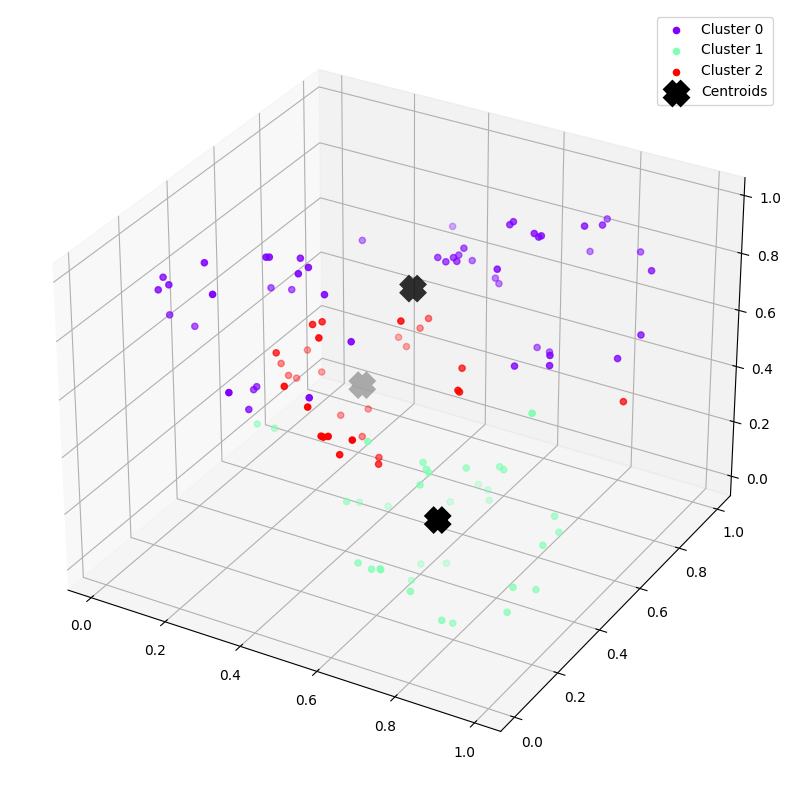

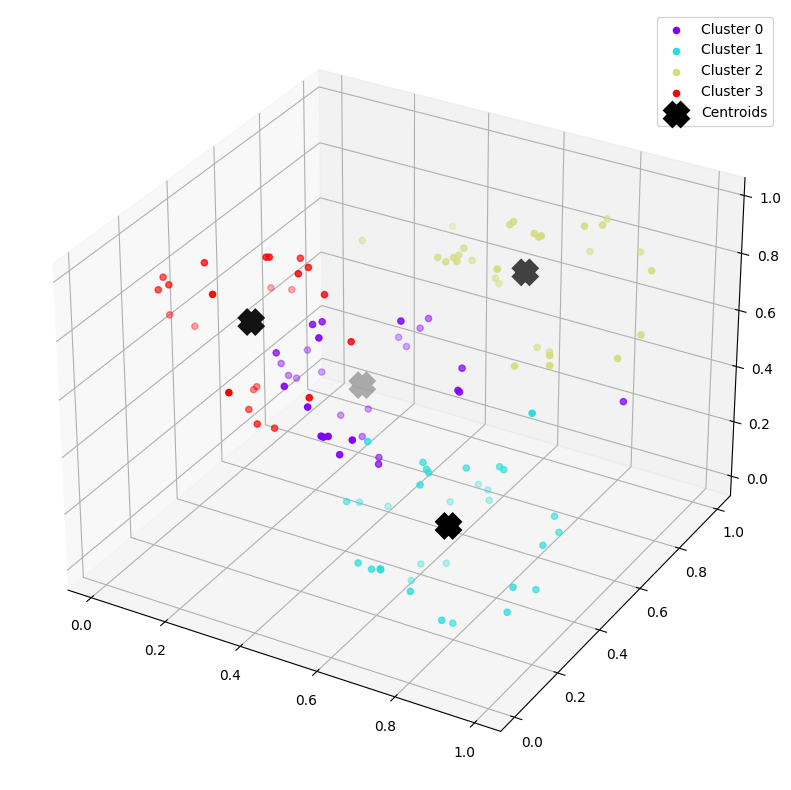

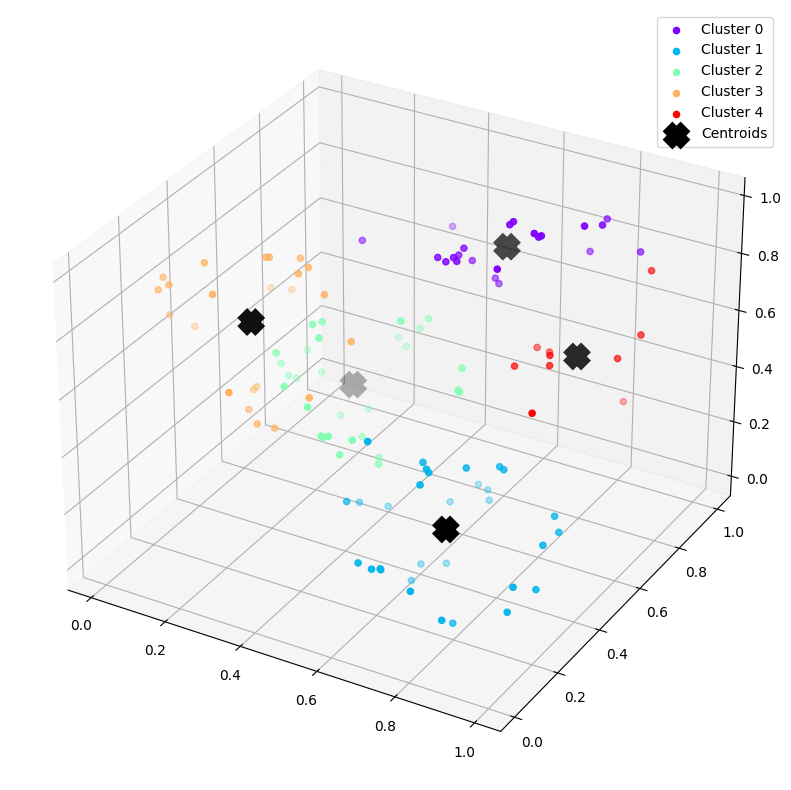

In [56]:
centroids_3 = kmeans_cluster_weirdos(coor_weirdos_Li, amount_clusters = 3)
centroids_4 = kmeans_cluster_weirdos(coor_weirdos_Li, amount_clusters = 4)
centroids_5 = kmeans_cluster_weirdos(coor_weirdos_Li, amount_clusters = 5)

print(f"centroids: \n {centroids_3}")
print(f"centroids: \n {centroids_4}")
print(f"centroids: \n {centroids_5}")

In [57]:
create_POSCAR_weirdos_centroids_appended(coor_weirdos_Li, centroids_4, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids")

plot_distweirdos(file_loc_important_cols)

In [58]:
file_loc_important_cols.columns

Index(['geometry', 'path', 'subdir_new_system', 'g+p', 'g+p+1', 'g+p-1',
       'perfect_system', 'p_s_mask', 'toten [eV]', 'subdir_CONTCAR',
       'subdir_positive_CONTCAR', 'coor_structure_init_dict', 'flag_Li',
       'coor_weirdos_Li', 'sum_weirdos_Li', 'duplicate_closest24_w_data_Li',
       'coor_reduced120_Li_closestduplicate', 'sum_mapped_Li_closestduplicate',
       'sum_sanitycheck_Li_closestduplicate',
       'atom_mapping_Li_closestduplicate',
       'atom_mapping_Li_w_dist_closestduplicate', 'flag_48htype2_Li',
       'coor_weirdos_48htype2_Li', 'sum_weirdos_48htype2_Li',
       'duplicate_closest24_w_data_48htype2_Li',
       'coor_reduced120_48htype2_Li_closestduplicate',
       'sum_mapped_48htype2_Li_closestduplicate',
       'sum_sanitycheck_48htype2_Li_closestduplicate',
       'atom_mapping_48htype2_Li_closestduplicate',
       'atom_mapping_48htype2_Li_w_dist_closestduplicate',
       'flag_48htypesmerged_Li', 'atom_mapping_48htypesmerged_Li',
       'coor_reduced

In [59]:
# file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_weirdos_Li","sum_weirdos_48htype2_Li","dist_weirdos_atom"dist_weirdos_48htype2_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
if activate_radius == 3:
    file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
    file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]]
    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}"
elif activate_radius == 2:
    file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
    file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]]
    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}"
elif activate_radius == 1:
    if litype == 2:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","toten [eV]"]]
    elif litype == 3:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","toten [eV]"]]
    elif litype == 4:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","toten [eV]"]]
    elif litype == 5:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","toten [eV]"]]

    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}"

In [60]:
file_loc_important_cols_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
file_loc_important_cols_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [61]:
xxxx - xx

NameError: name 'xxxx' is not defined

In [ ]:
dataframe = file_loc_important_cols

col_top1_sorted_idxweirdo_dist_el = "top1_sorted_idxweirdo_dist_Li"
col_top1_sorted_idxweirdo_label_el = "top1_sorted_idxweirdo_label_Li"
col_top1_sorted_idxweirdo_coor_el = "top1_sorted_idxweirdo_coor_Li"
col_top1_sorted_idxweirdo_file_el = "top1_sorted_idxweirdo_file_Li"

val = 0.

dist_weirdos_el_appendend = []
y_appended = []
label_weirdos_el_appended = []
coor_weirdos_el_appended = []
file_weirdos_el_appended = []

for idx in range(dataframe["geometry"].size):
    dist_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_dist_el].values()
    label_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_label_el].values()
    coor_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_coor_el].values()
    file_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_file_el].values()

    for single_dist in dist_weirdos_el:
        dist_weirdos_el_appendend.append(single_dist[0])
        y_appended.append(np.zeros_like(single_dist[0]) + val)

    for single_label in label_weirdos_el:
        label_weirdos_el_appended.append(single_label[0])

    for single_coor in coor_weirdos_el:
        coor_weirdos_el_appended.append(single_coor[0])
    
    for single_file in file_weirdos_el:
        file_weirdos_el_appended.append(single_file[0])

df = pd.DataFrame({'dist': dist_weirdos_el_appendend, 'label': label_weirdos_el_appended, 'y': y_appended, 'coor': coor_weirdos_el_appended, 'file': file_weirdos_el_appended})

# fig = px.scatter(df, x = 'dist', y = 'y', color='label', color_discrete_map={'48htype1': 'red', '48htype2': 'blue', '24g': 'green'})
fig = px.scatter(df, 
                 x = 'dist', 
                 y = 'y', 
                 color ='label', 
                 hover_data = ['dist', 'label', 'coor', 'file'])


fig.show(config={'scrollZoom': True})

In [ ]:
0.04718813922672343

In [ ]:
# from sklearn.cluster import MeanShift, estimate_bandwidth

# x = [1,1,5,6,1,5,10,22,23,23,50,51,51,52,100,112,130,500,512,600,12000,12230]

# X = np.array(list(zip(x,np.zeros(len(x)))), dtype='int')
# bandwidth = estimate_bandwidth(X, quantile=0.1)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# for k in range(n_clusters_):
#     my_members = labels == k
#     print("cluster {0}: {1}".format(k, X[my_members, 0]))

In [ ]:
# DBSCAN
# source: https://stackoverflow.com/questions/11513484/1d-number-array-clustering

# points = [0.1, 0.31,  0.32, 0.45, 0.35, 0.40, 0.5 ]
points = dist_weirdos_el_appendend

clusters = []
# eps = 0.2
eps = 0.043
points_sorted = sorted(points)
curr_point = points_sorted[0]
curr_cluster = [curr_point]
for point in points_sorted[1:]:
    if point <= curr_point + eps:
        curr_cluster.append(point)
    else:
        clusters.append(curr_cluster)
        curr_cluster = [point]
    curr_point = point
clusters.append(curr_cluster)
print(clusters)

In [ ]:
for i in clusters:
    print(i)

In [ ]:
clusters[0][int(len(clusters[0])/2)]

In [ ]:
len(clusters[0])

In [ ]:
len(clusters)

## another idea: plot based on litype

In [ ]:
# from sklearn.datasets import make_swiss_roll

# X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
        # # source: https://plotly.com/python/v3/3d-point-clustering/
        # scatter = dict(
        #     mode = "markers",
        #     name = "y",
        #     type = "scatter3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2],
        #     # x = tuple(coordinates[0]), y = tuple(coordinates[1]), z = tuple(coordinates[2]),
        #     marker = dict( size=2, color="rgb(23, 190, 207)" )
        # )

        # clusters = dict(
        #     alphahull = 7,
        #     name = "y",
        #     opacity = 0.1,
        #     type = "mesh3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2]
        # )

        # layout = dict(
        #     title = '3d point clustering',
        #     scene = dict(
        #         xaxis = dict( zeroline=False ),
        #         yaxis = dict( zeroline=False ),
        #         zaxis = dict( zeroline=False ),
        #     )
        # )

        # fig = dict( data=[scatter, clusters], layout=layout )

        # # Use py.iplot() for IPython notebook
        # pyoff.iplot(fig, filename='3d point clustering')

        # scatter = go.Scatter3d(
        #     mode="markers",
        #     name="y",
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2],
        #     marker=dict(size=2, color="rgb(23, 190, 207)")
        # )

        # clusters = go.Mesh3d(
        #     alphahull=7,
        #     name="y",
        #     opacity=0.1,
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2]
        # )

        # layout = go.Layout(
        #     title='3d point clustering',
        #     scene=dict(
        #         xaxis=dict(zeroline=False),
        #         yaxis=dict(zeroline=False),
        #         zaxis=dict(zeroline=False),
        #     )
        # )

        # fig = go.Figure(data=[scatter, clusters], layout=layout)

        # # Use iplot() for offline plotting
        # # iplot(fig, filename='3d point clustering')
        # pyoff(fig, filename='3d point clustering')

In [ ]:
get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")
get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "trf_w_linalg_orientated_positive_lessthan1", angle_in_degrees=True)
get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
max_neighbors_radius = 5
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
# file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_positive_S"][45]

In [ ]:
# my_dict = file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_positive_Li"][45]

# max_length = max(len(lst) for lst in my_dict.values())

# # Fill in missing values with None to make all lists the same length
# for key in my_dict:
#     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # Create a DataFrame from the modified dictionary
# df_my_dict = pd.DataFrame(my_dict)

# df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# df_my_dict = df_my_dict.sort_index(axis=1)
# df_my_dict = df_my_dict.transpose()
# # Save the DataFrame to an Excel file without the index
# df_my_dict.to_excel('neighbors_Li_trf_w_linalg_orientated_positive_45.xlsx', index=True)

In [ ]:
get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "CONTCAR")
get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "CONTCAR", angle_in_degrees=True)
get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "CONTCAR")

In [ ]:
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "CONTCAR")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "CONTCAR")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "CONTCAR")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "CONTCAR")

In [ ]:
# # # file_loc_important_cols["distance_cartesian_CONTCAR_S"][45]

In [ ]:
# # # my_dict = file_loc_important_cols["distance_cartesian_CONTCAR_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_CONTCAR_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")
get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "trf_w_linalg_orientated", angle_in_degrees=True)
get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")

In [ ]:
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated")
get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated")

In [ ]:
# # # my_dict = file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_trf_w_linalg_orientated_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
# file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","dist_weirdos_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]]

file_loc_important_cols_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
file_loc_important_cols_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [ ]:
file_loc_important_cols['scaling'][48]

In [ ]:
file_loc_important_cols['translation'][48]

In [ ]:
lattice_constants_1_0 = [[10.0222501477270232, -0.0006786050655888, -0.0018947275007341], [-0.0006784775666570, 10.0236290992971000, 0.0006784775666570], [-0.0018947275007341, 0.0006786050655888, 10.0222501477270232]]

In [ ]:
np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48].T)

In [ ]:
new_lattice_constant_1_0 = np.round(np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48].T) + file_loc_important_cols['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial', new_lattice_constant_1_0)

In [ ]:
-0.11331824 + 1.89472750e-03

In [ ]:
1.00236291e+01 + 0.2500525

In [ ]:
-6.78477567e-04 + 0.38668173

In [ ]:
new_lattice_constant_1_0_precision = np.round(new_lattice_constant_1_0, decimals=16)

In [ ]:
new_lattice_constant_1_0_precision

In [ ]:
direc_restructure_destination

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_pymatgen.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_lib.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_linalg.cif').lattice

In [ ]:
new_lattice_constant_1_0_nottransposed = np.round(np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48]) + file_loc_important_cols['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial_not_transposed', new_lattice_constant_1_0_nottransposed)

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit_not_transposed').lattice